In [61]:
import matplotlib.image as mpimg
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from s2cloudless import S2PixelCloudDetector, download_bands_and_valid_data_mask
from matplotlib.colors import ListedColormap
import datetime as dt
import plotly.io as pio
import copy
from datetime import datetime
import rasterio
from functools import lru_cache
from numba import jit
from osgeo import gdal
import subprocess
import os
import glob
from contextlib import contextmanager
import shutil


@contextmanager
def cwd(path):
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in sorted(os.listdir(d))]

class preprocessing:
    def __init__(self, caminho):
        self.caminho = caminho
        self.imgs_diretorio = os.listdir(self.caminho)
        self.diretorios_tif = sorted([diretorio.replace('.SAFE','.TIF') for diretorio in self.imgs_diretorio if diretorio.endswith('.SAFE')])
        self.caminho_completo_lista = [item for item in listdir_fullpath(self.caminho) if item.endswith('.SAFE')]
        
    def merge_tif_files(self, nome_TIF):
        pasta_TIF = nome_TIF
        with cwd(pasta_TIF):
            if os.path.exists(f'merge.tif'):
                os.remove(f'merge.tif')
            arquivos_tif = glob.glob('*.tif')
            comando = ['gdal_merge.py', '-o', f'merge.tif', '-of', 'Gtiff', '-separate', '-ot', 'FLOAT32'] + arquivos_tif
            subprocess.run(comando, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            list(map(os.remove,arquivos_tif))

        
    def _create_tif_folder(self) -> None:
        # Se a string terminar com '.SAFE', remova '.SAFE'; caso contrário, se terminar com '.TIF', remova '.TIF'
        diretorios_sem_extensao = [diretorio.replace('.SAFE', '').replace('.TIF', '') for diretorio in self.imgs_diretorio if diretorio.endswith('.SAFE') or diretorio.endswith('.TIF')]
        
        for nomes_dos_diretorios in diretorios_sem_extensao:
            
            if os.path.exists(f'{nomes_dos_diretorios}.TIF'):
                shutil.rmtree(f'./{nomes_dos_diretorios}.TIF')
            os.makedirs(f'{nomes_dos_diretorios}.TIF')
                    
        self._modify_img_diretorio()
        
        
    def _modify_img_diretorio(self) -> None:
        self.imgs_diretorio = [diretorio for diretorio in self.imgs_diretorio if diretorio.endswith('.SAFE')]
        
        
    def jp2_to_tif(self,merge_tif=True):
        
        with cwd(self.caminho):
            self._create_tif_folder()
            for diretorio in self.imgs_diretorio:
                files = glob.glob(os.path.join(f'{diretorio}','GRANULE', '*', 'IMG_DATA', '*B*.jp2'))
                files = sorted(files)
                nome_TIF = diretorio.replace('.SAFE','.TIF')
                commands = []
                for f in files:
                    input_path = f
                    output_path = nome_TIF + '/' +os.path.splitext(os.path.basename(f))[0] + '.tif'
                    
                    if os.path.exists(output_path):
                        os.remove(output_path)
                    cmd = ['gdal_translate', input_path, '-ot', 'Float32', '-of', 'Gtiff', '-outsize', '1830', '1830', output_path]
                    commands.append(cmd)
                for cmd in commands:
                    subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                if merge_tif:
                    self.merge_tif_files(nome_TIF)
                
    def _criar_symlinks(self,kappa_mask_folder):

        # Caminho para a pasta origem
        pasta_origem = os.path.abspath(kappa_mask_folder)

        for diretorio in self.caminho_completo_lista:
            # Caminho para a pasta destino (dinâmica)
            caminho_pasta = self.caminho + '/' + diretorio
            
            pasta_destino = os.path.abspath(caminho_pasta)

            # Caminho completo para o symlink dentro da pasta origem
            symlink_path = os.path.join(pasta_origem, "data", os.path.basename(pasta_destino))

            # Criar o symlink
            try:
                os.symlink(pasta_destino, symlink_path)
                print(f"Symlink criado com sucesso: {symlink_path} -> {pasta_destino}")
            except FileExistsError:
                return
            except Exception as e:
                print(f"Erro ao criar symlink: {e}")
    
    
class Modelos(preprocessing):
    def __init__(self, caminho):
        super().__init__(caminho)
        
    def start(self):
        self.jp2_to_tif()
        
    def s2cloudless(self, threshold=0.4, average_core=22, dilation_size=11, all_bands=True) -> list:
        for diretorio in self.diretorios_tif:
            caminho_completo = self.caminho + '/' + diretorio
            if os.path.exists(caminho_completo):
                with cwd(caminho_completo):
                    bandas = gdal.Open(f'./merge.tif').ReadAsArray()
                    bandas = np.transpose(bandas, (1, 2, 0))
                    cloud_detector = S2PixelCloudDetector(threshold=threshold, average_over=average_core, dilation_size=dilation_size, all_bands=all_bands)
                    cloud_prob = cloud_detector.get_cloud_probability_maps(bandas[np.newaxis, ...])
                    cloud_mask = cloud_detector.get_cloud_masks(bandas[np.newaxis, ...])
                    yield [cloud_prob, cloud_mask]
            else:
                self.start()
    
    def fmask(self) -> None:
        for pasta in self.caminho_completo_lista:
            yield self._processar_resultados_fmask(pasta)

    def _processar_resultados_fmask(self, pasta):
        pasta += '/GRANULE'
        temp = os.listdir(pasta)[0]  # L1C*

        with cwd(os.path.join(pasta, temp)):
            cmd = ["/usr/GERS/Fmask_4_6/application/run_Fmask_4_6.sh", "/usr/local/MATLAB/MATLAB_Runtime/v910"]

            # Inicia o subprocesso
            subprocess.run(cmd)

            # Encontra os arquivos de resultados gerados pelo Fmask
            resultados_scl = glob.glob('FMASK_DATA/*')[0]
            resultados = gdal.Open(resultados_scl).ReadAsArray()
            return resultados

        
    def kappa_mask(self,kappa_mask_folder,json_config_name='config_example.json'):
        self._criar_symlinks(kappa_mask_folder)
         
        for product_name in self.imgs_diretorio:
            yield self._processar_resultados_kappaMask(kappa_mask_folder,product_name,json_config_name)
        
        
    def _processar_resultados_kappaMask(self,kappa_mask_folder,product_name,json_config_name):
        
        config_dict = {
          "cm_vsm_executable" : "cm_vsm",
          "folder_name": "data",
          "product_name": f"{product_name}",
          "level_product": "L2A",
          "overlapping": 0.0625,
          "tile_size": 512,
          "resampling_method" : "sinc",
          "architecture": "Unet",
          "batch_size": 1,
          "aoi_geometry": ""
        }
        
        caminho_json_config = f'./config/{json_config_name}'
        
        with cwd(kappa_mask_folder):
            with open(caminho_json_config, 'w') as arquivo:
                json.dump(config_dict, arquivo, indent=2)
        
        
        
    
    def sen2cor(self,sen2cor_folder='../Sen2Cor-02.11.00-Linux64/',resolucao=60):
        for diretorio in self.caminho_completo_lista:
            yield self._processar_resultados_sen2cor(sen2cor_folder,resolucao)
            
    def _processar_resultados_sen2cor(self, sen2cor_folder, resolucao=60):
        with cwd(self.caminho):
            for diretorio in self.caminho_completo_lista:
                dir_index = self.caminho_completo_lista.index(diretorio)

                temp = self.imgs_diretorio[dir_index].split('_')

                diretorio_substring = '_'.join(temp[:3])
                
                output_path = os.path.abspath(obj.diretorios_tif[dir_index])
                
                # Executa o Sen2Cor para processar os dados
                comando = f"{sen2cor_folder}/bin/L2A_Process {diretorio} --resolution {resolucao} --output_dir {output_path}"

                subprocess.run(comando, shell=True)
                
                safe_dir = [item for item in os.listdir(output_path) if item.endswith('.SAFE')][0]
                
                caminho_scl = os.path.join(f'{output_path}',f"{safe_dir}", 'GRANULE', 'L2A*', 'IMG_DATA', 'R60m', '*SCL_60m.jp2')
                
                # Obtém uma lista de arquivos SCL_60m.jp2 nos diretórios correspondentes
                resultados_scl = glob.glob(caminho_scl)[0]
                
                # Processa os resultados conforme necessário
                classification_map = gdal.Open(resultados_scl).ReadAsArray()

                return classification_map
        
        
                
obj = Modelos('./')
#obj.start() # Executar uma vez

In [60]:
obj.caminho_completo_lista

['./S2A_MSIL1C_20230918T144731_N0509_R139_T19LGL_20230918T180815.SAFE',
 './S2B_MSIL1C_20220705T135709_N0400_R067_T21MYS_20220705T172624.SAFE',
 './S2B_MSIL1C_20230604T151709_N0509_R125_T18MXA_20230604T181707.SAFE',
 './S2B_MSIL1C_20231010T143729_N0509_R096_T20MMC_20231010T180007.SAFE']

In [62]:
teste = obj.kappa_mask('../km_predict-main')

Symlink criado com sucesso: /home/jean/Documents/Python/km_predict-main/data/S2A_MSIL1C_20230918T144731_N0509_R139_T19LGL_20230918T180815.SAFE -> /home/jean/Documents/Python/sen2corimgs/S2A_MSIL1C_20230918T144731_N0509_R139_T19LGL_20230918T180815.SAFE
Symlink criado com sucesso: /home/jean/Documents/Python/km_predict-main/data/S2B_MSIL1C_20220705T135709_N0400_R067_T21MYS_20220705T172624.SAFE -> /home/jean/Documents/Python/sen2corimgs/S2B_MSIL1C_20220705T135709_N0400_R067_T21MYS_20220705T172624.SAFE
Symlink criado com sucesso: /home/jean/Documents/Python/km_predict-main/data/S2B_MSIL1C_20230604T151709_N0509_R125_T18MXA_20230604T181707.SAFE -> /home/jean/Documents/Python/sen2corimgs/S2B_MSIL1C_20230604T151709_N0509_R125_T18MXA_20230604T181707.SAFE
Symlink criado com sucesso: /home/jean/Documents/Python/km_predict-main/data/S2B_MSIL1C_20231010T143729_N0509_R096_T20MMC_20231010T180007.SAFE -> /home/jean/Documents/Python/sen2corimgs/S2B_MSIL1C_20231010T143729_N0509_R096_T20MMC_20231010T1800

In [3]:
prob,mask = next(obj.s2cloudless())

In [35]:
mapa_de_classificacao = next(obj.sen2cor())

Product versions > 14.9 are not implemented yet.
Version 14.9 will be used by default, but warnings during validation might occur.

Sen2Cor. Version: 02.11.00, created: 2022.10.20, supporting Level-1C product version 14.2 - 14.9 started ...
Product version: 14.9
Operation mode: TOOLBOX
Processing baseline: 99.99
Progress[%]:  0.00 : Generating datastrip metadata
L2A datastrip successfully generated
Selected resolution: 60 m
Progress[%]: 0.77 : PID-47374, L2A_ProcessTile: processing with resolution 60 m, elapsed time[s]: 1.000, total: 0:00:05.019156
Progress[%]: 0.77 : PID-47374, L2A_ProcessTile: start of pre processing, elapsed time[s]: 0.000, total: 0:00:05.019474
Progress[%]: 0.80 : PID-47374, L2A_Tables: start import, elapsed time[s]: 0.039, total: 0:00:05.058408
Progress[%]: 1.61 : PID-47374, L2A_Tables: band B01 imported, elapsed time[s]: 1.037, total: 0:00:06.095117
Progress[%]: 4.43 : PID-47374, L2A_Tables: band B02 imported, elapsed time[s]: 3.652, total: 0:00:09.747356
Progres

In [53]:
mascara_de_classificacao = next(obj.fmask())

------------------------------------------
Setting up environment variables
---
LD_LIBRARY_PATH is .:/usr/local/MATLAB/MATLAB_Runtime/v910/runtime/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/v910/bin/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/v910/sys/os/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/v910/sys/opengl/lib/glnxa64
Fmask 4.6 start ...
Cloud/cloud shadow/snow dilated by 3/3/0 pixels.
Cloud probability threshold of 20.00%.
Load or calculate TOA reflectances.
Successully locate the auxiliary data.
Detect potential clouds, cloud shadows, snow, and water.
Match cloud shadows with clouds.
Fmask 4.6 finished (6.79 minutes)
for L1C_T19LGL_A043036_20230918T144729 with 52.74% clear pixels

FMASK_DATA/L1C_T19LGL_A043036_20230918T144729_Fmask4.tif
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  4   4   4 ... 255 255 255]
 [  4   4   4 ... 255 255 255]
 [  4   4   4 ... 255 255 255]]


In [69]:
subprocess.Popen('micromamba --version',shell=True)

/bin/sh: 1: micromamba: not found


<Popen: returncode: None args: 'micromamba --version'>

## SOM (Não mexer)

In [3]:
# import required libraries
import h5py as h5
import numpy as np

# Read H5 file
# This file carries a database with spectra for cloud masking applications. It was created during the study described in https://doi.org/10.3390/rs8080666
# It can be downloaded from https://git.gfz-potsdam.de/EnMAP/sentinel2_manual_classification_clouds

f = h5.File("20160914_s2_manual_classification_data.h5", "r")

# Get and print list of datasets within the H5 file
datasetNames = [n for n in f.keys()]
for n in datasetNames:
        print(n)
        
# extract reflectance data from the H5 file

#class_ids 
class_ids=f['class_ids']
class_idsData=class_ids[:]

#class_names
class_names=f['class_names']
print(class_names[:])

#spectra
spectra=f['spectra'] 
spectraData=spectra[:]   

#classes
classes=f['classes'] 
classesData=classes[:]  

# Create array that contains the spectra and the class labels
'''Each row contains 14 collumns: a) 13 collumns for the reflectance values of Sentinel-2 satellite spectra,
#b) one column for the label of the spectra. There are six classes, thus six different
 labels:"10:land", "20:water", "30:shadow", "40:cirrus", "50:opaque cloud", "60:snow".'''
classesData=np.expand_dims(classesData,1)
Array_spectra_labels=np.concatenate((spectraData,classesData), axis=1)

#Save the array with the spectra and the labels
np.savetxt("2016_spectraSOMs.csv", Array_spectra_labels, delimiter=',', header=" #B1,  #B2,  #B3,  #B4, #B5, #B6, #B7, #B8, #B8a, #B9, #B10, #B11, #B12, #label",fmt='%10.4f')

author
band
bandwidth_nm
central_wavelength_nm
cite
class_ids
class_names
classes
continent
country
dates
granule_id
latitude
licence
longitude
product_id
spatial_sampling_m
spectra
sun_azimuth_angle
sun_zenith_angle
viewing_azimuth_angle
viewing_zenith_angle
[b'Clear' b'Water' b'Snow' b'Cirrus' b'Cloud' b'Shadow']


In [5]:
#Detecting the BMUs

#Importing libraries
import numpy as np
import susi #The susi package can be found in https://pypi.org/project/susi/
import pickle

#Load the trained SOM
with open('SOM_trained.p', 'rb') as infile:
   som = pickle.load(infile)

#size: number of rows of the training set
size=len(X_train) #X_train was defined in "data_preprocessing.py"

#Separating the training spectra into smaller arrays 
X_train1=X_train[0:1000000,:]
X_train2=X_train[1000000:2000000,:]
X_train3=X_train[2000000:3000000,:]
X_train4=X_train[3000000:4000000,:]
X_train5=X_train[4000000:5000000,:]
X_train6=X_train[5000000:6000000,:]
X_train7=X_train[6000000:7000000,:]
X_train8=X_train[7000000:8000000,:]
X_train9=X_train[8000000:size,:]

#Detecting the coordinates of the Best Matching Units (BMUs) for each spectral signature of the training set. The coordinates are stored in a list data type.
print(" Cluster 1" )
clusters1 = som.get_clusters(X_train1)
print(" Cluster 2" )
clusters2 = som.get_clusters(X_train2)
print(" Cluster 3" )
clusters3 = som.get_clusters(X_train3)
print(" Cluster 4" )
clusters4 = som.get_clusters(X_train4)
print(" Cluster 5" )
clusters5 = som.get_clusters(X_train5)
print(" Cluster 6" )
clusters6 = som.get_clusters(X_train6)
print(" Cluster 7" )
clusters7 = som.get_clusters(X_train7)
print(" Cluster 8" )
clusters8 = som.get_clusters(X_train8)
print(" Cluster 9" )
clusters9 = som.get_clusters(X_train9)

#Joining all BMU lists to one
clusters=clusters1+clusters2+clusters3+clusters4+clusters5+clusters6+clusters7+clusters8+clusters9

#Creating an array data type to store the BMUs
BMUs=np.zeros((size,2))

for i in range (size):
    BMUs[i,:]=clusters[i]

#Saving the BMUs in a .csv file
np.savetxt('BMUs.csv', BMUs, delimiter=',', header="position1, #position2", fmt='%10.0f')

 Cluster 1
 Cluster 2
 Cluster 3
 Cluster 4
 Cluster 5
 Cluster 6
 Cluster 7
 Cluster 8
 Cluster 9


In [1]:
#Convert a Sentinel-2 image with 13 bands to a .csv file. 
#Each row of the output file contains the 13 values of the spectral signature

    
import os
import pandas as pd
from osgeo import gdal
from os.path import splitext
import numpy as np
import time

try:
    directory = os.listdir('../sen2corimgs/L1C_IMAGEM_1/img tif/')
    os.chdir('../sen2corimgs/L1C_IMAGEM_1/img tif/')
except:
    directory = ['merge.tif']

c=0
start_time = time.time()   

for file in directory:
    c=c+1
    print(" The file number is %s" %c) 
    print("--- %s seconds ---" % (time.time() - start_time)) 
    ds=gdal.Open(file) 
    imarray = np.array(ds.ReadAsArray())
    print(imarray.shape)
    sizex=  ...# enter size of image, i.e. rows x collumns
    reshape=np.reshape(imarray, (13,1830*1830)) # '13' is the number of bands
    reshape2=reshape.T
    reshape3=reshape2/10000 # scaling the values
    file_name = os.path.basename(file)
    new_filename = file_name.split('.')[0]
    np.savetxt(new_filename + "_converted.csv", reshape3, delimiter=',', header=" #B1,  #B2,  #B3,  #B4, #B5, #B6, #B7, #B8, #B8a, #B9, #B10, #B11, #B12",fmt='%10.4f')
    break

 The file number is 1
--- 0.0002605915069580078 seconds ---
(13, 1830, 1830)
 The file number is 2
--- 19.32036519050598 seconds ---


ERROR 4: `.ipynb_checkpoints' not recognized as a supported file format.


AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

In [1]:
#Data preprocessing

# Importing the libraries
import numpy as np
import pandas as pd

# Importing the datasets
# The datasets are two .csv files which were created by extracting the spectra from two .h5 files as explained in the file "read_h5file.py". Each row contains 14 collumns: a) 13 collumns for the reflectance values of Sentinel-2 satellite spectra, b) one column for the label of the spectra. There are six classes, thus six different labels:"10:land", "20:water", "30:shadow", "40:cirrus", "50:opaque cloud", "60:snow".  

dataset1 = pd.read_csv('2016_spectraSOMs.csv') #.csv file with spectra extracted from the first .h5 file.
#X_train1 = dataset1.iloc[:, 'collumn of 1st band':'collumn of last band'].values
X_train1 = dataset1.iloc[:, 0:13].values
#y1=dataset1.iloc[:, "collumn with labels"].values
y1=dataset1.iloc[:, 13].values

dataset2 = pd.read_csv('2017_spectraSOMs.csv') #.csv file with spectra extracted from the second .h5 file.
#X_train2 = dataset2.iloc[:, 'collumn of 1st band':'collumn of last band'].values
X_train2 = dataset2.iloc[:, 0:13].values
#y2=dataset2.iloc[:, "collumn with labels"].values
y2=dataset2.iloc[:, 13].values

# Concatenating the spectra of the two datasets in one array
X_traina=np.concatenate((X_train1,X_train2), axis=0) 

# Concatenating the labels of the two datasets in one array
ya=np.concatenate((y1,y2), axis=0)

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X_train = sc.fit_transform(X_traina)

# Take a random sample in case the training process is slow
#Define a seed to get the same indices in every run
#np.random.seed(seed=42)
#random_indices = np.random.choice(len(X_train), size=1000000, replace=False)

#X_train=X_train[random_indices,:]

In [2]:
size=len(X_train) #X_train was defined in "data_preprocessing.py"

In [3]:
import pickle
with open('./SOM_trained.p', 'rb') as infile:
   som = pickle.load(infile)

In [4]:
#Labeling of SOM neurons through majority voting

#Importing libraries
import numpy as np
import pandas as pd

#Reading the .csv file that contains the coordinates of the Best Matching Units (BMUs) for each spectral signature of the training set.

BMUs = pd.read_csv('BMUs.csv') #The "BMUs.csv" file was created in "BMUs_detection.py"         
BMUs2=np.array(BMUs)

#Creating an array of zeros which is of equal size to the SOM grid for each of the six classes
Hit1=np.zeros((20,15))
Hit2=np.zeros((20,15))
Hit3=np.zeros((20,15))
Hit4=np.zeros((20,15))
Hit5=np.zeros((20,15))
Hit6=np.zeros((20,15))

#Creating the hit rate map for each class
#ya: the data labels ("ya" is created in "data_preprocessing.py")
for i in range (size):
    if (ya[i]==10):
        Hit1[int(BMUs2[i,0]),int(BMUs2[i,1])]=Hit1[int(BMUs2[i,0]),int(BMUs2[i,1])]+1
    elif (ya[i]==20):
        Hit2[int(BMUs2[i,0]),int(BMUs2[i,1])]=Hit2[int(BMUs2[i,0]),int(BMUs2[i,1])]+1         
    elif (ya[i]==40):
        Hit3[int(BMUs2[i,0]),int(BMUs2[i,1])]=Hit3[int(BMUs2[i,0]),int(BMUs2[i,1])]+1        
    elif(ya[i]==50):
        Hit4[int(BMUs2[i,0]),int(BMUs2[i,1])]=Hit4[int(BMUs2[i,0]),int(BMUs2[i,1])]+1 
    elif(ya[i]==60):
        Hit5[int(BMUs2[i,0]),int(BMUs2[i,1])]=Hit5[int(BMUs2[i,0]),int(BMUs2[i,1])]+1    
    elif(ya[i]==30):
        Hit6[int(BMUs2[i,0]),int(BMUs2[i,1])]=Hit6[int(BMUs2[i,0]),int(BMUs2[i,1])]+1        

#Labeling of SOM neurons

#Creating an array of zeros which is of equal size to the SOM grid and store the majority voting output
labels= np.zeros((20,15))
for i in range (20):
    for j in range (15):
        if (Hit1[i,j]>Hit2[i,j] and Hit1[i,j]>Hit3[i,j] and Hit1[i,j]>Hit4[i,j] and Hit1[i,j]>Hit5[i,j] and Hit1[i,j]>Hit6[i,j]):
            labels[i,j]=10
        elif (Hit2[i,j]>Hit1[i,j] and Hit2[i,j]>Hit3[i,j] and Hit2[i,j]>Hit4[i,j] and Hit2[i,j]>Hit5[i,j] and Hit2[i,j]>Hit6[i,j]):
            labels[i,j]=20
        elif (Hit3[i,j]>Hit1[i,j] and Hit3[i,j]>Hit2[i,j] and Hit3[i,j]>Hit4[i,j] and Hit3[i,j]>Hit5[i,j] and Hit3[i,j]>Hit6[i,j]):
            labels[i,j]=40           
        elif (Hit4[i,j]>Hit1[i,j] and Hit4[i,j]>Hit2[i,j] and Hit4[i,j]>Hit3[i,j] and Hit4[i,j]>Hit5[i,j] and Hit4[i,j]>Hit6[i,j]):
            labels[i,j]=50    
        elif (Hit5[i,j]>Hit1[i,j] and Hit5[i,j]>Hit2[i,j] and Hit5[i,j]>Hit3[i,j] and Hit5[i,j]>Hit4[i,j] and Hit5[i,j]>Hit6[i,j]):
            labels[i,j]=60  
        elif (Hit6[i,j]>Hit1[i,j] and Hit6[i,j]>Hit2[i,j] and Hit6[i,j]>Hit3[i,j] and Hit6[i,j]>Hit4[i,j] and Hit6[i,j]>Hit5[i,j]):
            labels[i,j]=30 


In [5]:
#Create cloud masks

#Conversion of the six classes to two (cloud:"40,50", non-cloud:"10,20,30,60")
label2=np.zeros((20,15))

for i in range(20):
    for j in range(15):
        if labels[i,j]==40 or labels[i,j]==50:
            label2[i,j]=255

#Importing libraries
import os, re
import pandas as pd
from os.path import splitext
import numpy as np
import tifffile as tiff
import time


os.chdir('../sen2corimgs/L1C_IMAGEM_1/img tif/')

try:
    directory = os.listdir('./csv folder/')
    os.chdir('./csv folder/')
except:
    directory = ['merge_converted.csv']
    
#Sorting the directory according to the names of the files 
directory2=sorted(directory)

c=0
start_time = time.time()
for file in directory2:
    c=c+1
    print(" The file number is %s" %c) 
    print("--- %s seconds ---" % (time.time() - start_time)) 
    
    #Reading the spectra for an image        
    im=pd.read_csv(file)  
    im2=np.array(im)  
 
    size=len(im)      

    im3= sc.transform(im2) #normalizes the test data based on the statistical parameters of the training data                

    #Separating the image spectra into smaller arrays. The size of each image is 1830x1830 pixels thus 3348900 spectra in total    
    X_test1=im3[0:500000,:]
    X_test2=im3[500000:1000000,:]
    X_test3=im3[1000000:1500000,:]
    X_test4=im3[1500000:2000000,:]
    X_test5=im3[2000000:2500000,:]
    X_test6=im3[2500000:3000000,:]
    X_test7=im3[3000000:size,:]
    
    #Detecting the coordinates of the Best Matching Units (BMUs) for each spectral signature. The coordinates are stored in a list data type.
    clusters1 = som.get_clusters(X_test1)    
    clusters2 = som.get_clusters(X_test2)
    print(" Cluster 3" )
    clusters3 = som.get_clusters(X_test3)
    clusters4 = som.get_clusters(X_test4)
    print(" Cluster 5" )
    clusters5 = som.get_clusters(X_test5)
    clusters6 = som.get_clusters(X_test6)    
    clusters7 = som.get_clusters(X_test7)
    print(" Finished clusters" )
    
    #Joining all BMU lists to one
    clusters=clusters1+clusters2+clusters3+clusters4+clusters5+clusters6+clusters7

    #Creating an array data type to store the BMUs
    im_BMUs=np.zeros((size,2))

    for i in range (size):
        im_BMUs[i,:]=clusters[i]

    #Creating an array to store the labels for the spectra of the image
    im_labels=np.zeros((size,1))

    for i in range(size):
        im_labels[i,0]=label2[int(im_BMUs[i,0]),int(im_BMUs[i,1])] #"labels2" was created in "labeling.py"

    #Creating the cloud mask 
    im_labels2=np.uint8(im_labels)      
    reshape=np.reshape(im_labels2,(1830,1830)) 
    file_name = os.path.basename(file)
    new_filename = file_name.split('.')[0]   
    tiff.imsave(new_filename + "mask.tif", reshape)

 The file number is 1
--- 0.0004763603210449219 seconds ---
 Cluster 3
 Cluster 5
 Finished clusters


/tmp/ipykernel_7668/2509982722.py:87: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(new_filename + "mask.tif", reshape)


In [3]:
converted_mask = gdal.Open('../sen2corimgs/L1C_IMAGEM_1/img tif/csv folder/merge_convertedmask.tif').ReadAsArray()
converted_mask.shape

(1830, 1830)

In [8]:
set(converted_mask[1])

{0, 255}

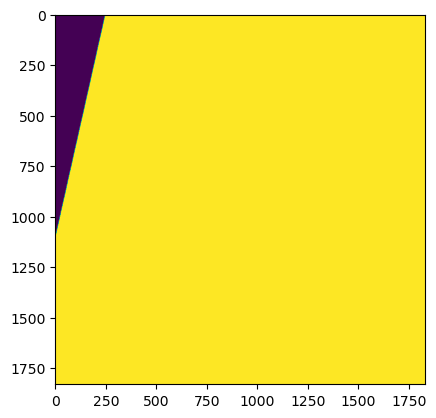

In [4]:
plt.imshow(converted_mask)